# Module 09: Model Emulation, Part 1: Ensemble Simulation

### 1. Introduction and Background

So, in our model for this week, there will be two parameters that require calibration:
* $T_t$: The threshold temperature used to decide whether precipitation is snow or if snowmelt is occuring, and
* $D_D$: The degree-day factor that will translate positive air temperature departures from $T_t$ into snowmelt rates

The system that we're modeling will be the East River Watershed in western Colorado, the site of a [major Earth science community effort to understand watershed function](https://watershed.lbl.gov/). We will use our model to make predictions of snow water equivalent (SWE) that we will compare against observed observations of SWE from a Snotel station within the watershed that has historically served as a good approximation of the total SWE within the watershed. We will compute a few error statistics relative to the observed historical values of SWE. We have 20 years of forcing data, but will only examine the last 5 years of the record.  

### 2. `Python` Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# This is a new, but powerful library for time series analysis and handling real-world dates
import pandas as pd
from scipy.stats import qmc

# The name of file that contains forcing and observed SWE during every day of water year 2001-2020
forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

date_beg = '2000-10-01' # This is the first day of water year 2000
date_end = '2015-09-30' # This is the last day of water year 2000

dt = 1 # Time step [day]

Nreps = 1000 # Number of replicates

DD_l = 1.0 # Lower bound of degree-day factor [mm/day/°C]
DD_u = 10.5 # Upper bound of degree-day factor [mm/day/°C]
Tt_l = -1.0 # Lower bound of temperature threshold [°C] 
Tt_u = 7.0 # Upper bound of temperature threshold [°C]

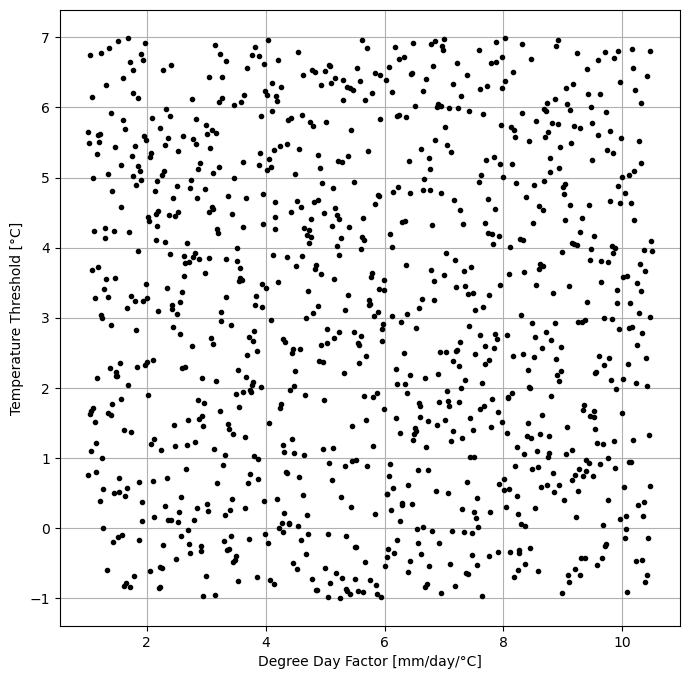

In [2]:
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(Nreps)

l_bounds = [DD_l, Tt_l]
u_bounds = [DD_u, Tt_u]

sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

plt.figure(figsize=(8,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

### 3. Read Forcing Data and Plot

In [3]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

# Here's what a pandas "dataframe" looks like:
df_forcing

,Date,tair,pcp,Q,SWE,PET
Date,,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,NaN,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,NaN,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,NaN,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,NaN,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,NaN,3.244371
...,...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,0.0,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,0.0,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,0.0,3.412351


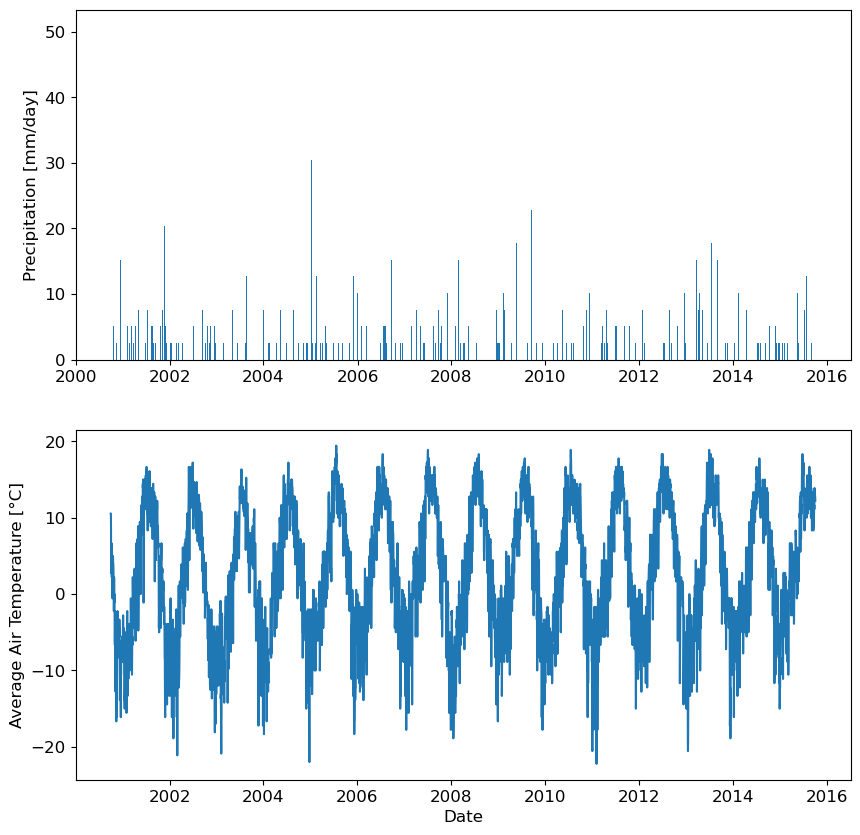

In [4]:
# Plot temperature and precipitation during the period
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.bar(df_forcing['Date'][date_beg:date_end].values,df_forcing['pcp'][date_beg:date_end].values)
plt.ylabel('Precipitation [mm/day]')
plt.subplot(2,1,2)
plt.plot(df_forcing['Date'][date_beg:date_end].values,df_forcing['tair'][date_beg:date_end].values)
plt.xlabel('Date')
plt.ylabel('Average Air Temperature [°C]')
plt.show()

### 4. Get Precipitation and Temperature Forcing Data 

Here we use our new `pandas` skills to get the values of the dates, precipitation, and temperature that coincide with the dates that we want to simulate.

In [5]:
ForcingDates = df_forcing[date_beg:date_end]['Date'].values
P = df_forcing[date_beg:date_end]['pcp'].values
Ta = df_forcing[date_beg:date_end]['tair'].values

### 5. Create Containers for Modeled Variables

In [6]:
t = pd.date_range(start=date_beg, end=date_end, freq='1D')
Nt = t.size

SWE = np.zeros((Nt,Nreps))
Sm = np.zeros((Nt,Nreps))
Pliq = np.zeros((Nt,Nreps))

### 5. Run the Snow-17 Model

In [7]:
for r in np.arange(Nreps):

    SWE_rep = np.zeros((Nt))
    Sm_rep = np.zeros((Nt))
    Pliq_rep = np.zeros((Nt))
    
    DD = sample_scaled[r,0]
    Tt = sample_scaled[r,1]
    
    for i in np.arange(Nt):

        P_i  = P[i] # The value of precipitation on this date
        Ta_i = Ta[i] # The value of average air temperature on this date

        # Initial conditions: we are starting when there should not be any appreciable snow in the watershed, 
        # so we will assume that SWE = 0. If you decide to run another date when there might be snow (e.g., Jan. 1)
        # then you would need a more realistic value of SWE.
        if(i==0):
            SWE_i = 0.0 
        else:
            SWE_i = SWE_rep[i-1] # The initial SWE on these dates is simply the SWE from the day before. We will add snow or subtract melt.
            
        # If SWE is greater than zero, there *may* be snowmelt
        if(SWE_i>0.0):
            if(Ta_i>Tt): # If the air temperature is greater than the threshold, there **will** be melt
                Sm_i = DD*(Ta_i-Tt) # Snowmelt via degree-day factor
            else: # If the air temperature is below the threshold, there is no melt
                Sm_i = 0.0 # No snowmelt if temperature does not exceed threshold
        else: # If there is no SWE, by definition there is no snowmelt
            Sm_i = 0.0
        
        # If there is precipitation, figure out its phase
        if((P_i>0.0) and (Ta_i<=Tt)):
            SWE_i += P_i # All precip will be added to SWE storage
            Pliq_i = 0.0 # There is no liquid precipitation
        elif((P_i>0.0) and (Ta_i>Tt)):
            Pliq_i = P_i # All precipitation falls as liquid. NOTE: We are assuming rain does not melt snow!!!
        else: # If there is no precipitation, there is nothing to accumulate
            Pliq_i = 0.0
        
        SWE_rep[i] = np.max([SWE_i - Sm_i,0.0]) # Make sure we can only melt as much SWE as there is. This only matters at low SWE
        Sm_rep[i] = Sm_i # Save the snowmelt... QUESTION: Is this something we can observe?!?!?!?!
        Pliq_rep[i] = Pliq_i
        
    SWE[:,r] = SWE_rep
    Sm[:,r] = Sm_rep
    Pliq[:,r] = Pliq_rep


### 6. Plot Results

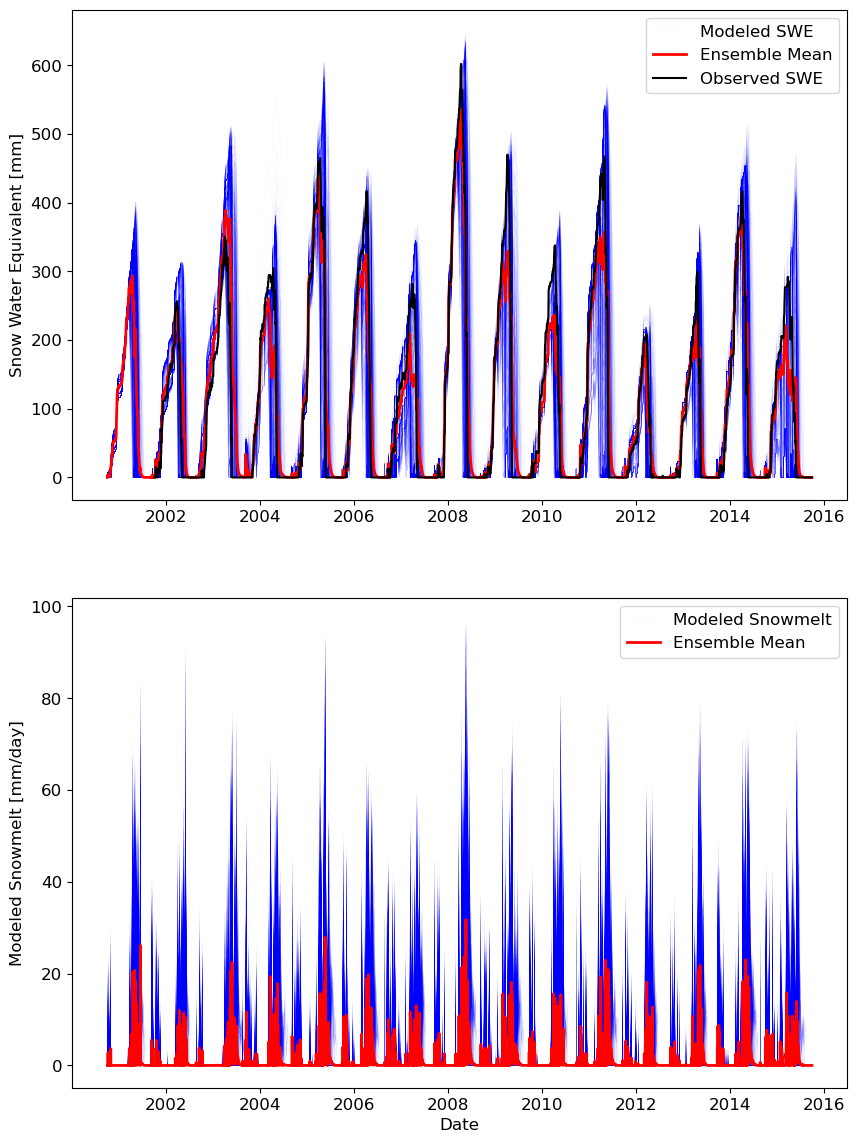

In [8]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,14))

for r in np.arange(Nreps):
    plt.subplot(2,1,1)
    if r == 0:
        plt.plot(t,SWE[:,r],'b-',label='Modeled SWE', linewidth=0.01)
    else:
        plt.plot(t,SWE[:,r],'b-', linewidth=0.01)
    
    plt.subplot(2,1,2)
    if r == 0:
        plt.plot(t,Sm[:,r],'b-',label='Modeled Snowmelt', linewidth=0.01)
    else:
        plt.plot(t,Sm[:,r],'b-', linewidth=0.01)

plt.subplot(2,1,1)
plt.plot(t,np.mean(SWE,1),'r-',label='Ensemble Mean', linewidth=2.0)
plt.plot(t,df_forcing[date_beg:date_end]['SWE'].values,'k-',label='Observed SWE')
plt.ylabel('Snow Water Equivalent [mm]')
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.plot(t,np.mean(Sm,1),'r-',label='Ensemble Mean', linewidth=2.0)
plt.xlabel('Date')
plt.ylabel('Modeled Snowmelt [mm/day]')
plt.legend(loc='upper right')
plt.show()


# 7. Save Results to a File

In [9]:
df_SWE_sim = pd.DataFrame()
df_SWE_sim['Dates'] = ForcingDates
for r in np.arange(Nreps):
    col_label = 'SWE rep '+str(r)
    df_SWE_sim.insert(r+1,col_label,SWE[:,r])
    df_SWE_sim = df_SWE_sim.copy() # Done to prevent fragmentation warning

df_SWE_sim

,Dates,SWE rep 0,SWE rep 1,SWE rep 2,SWE rep 3,SWE rep 4,SWE rep 5,SWE rep 6,SWE rep 7,SWE rep 8,...,SWE rep 990,SWE rep 991,SWE rep 992,SWE rep 993,SWE rep 994,SWE rep 995,SWE rep 996,SWE rep 997,SWE rep 998,SWE rep 999
0,2000-10-01,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.000000,0.0
1,2000-10-02,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.000000,0.0
2,2000-10-03,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.000000,0.0
3,2000-10-04,0.0,7.62,7.62,0.0,0.0,7.62,7.62,7.62,0.0,...,0.0,0.0,7.620000,7.62,0.0,7.620000,7.62,7.62,7.620000,0.0
4,2000-10-05,0.0,7.62,0.00,0.0,0.0,7.62,7.62,7.62,0.0,...,0.0,0.0,1.534152,7.62,0.0,5.517573,7.62,7.62,1.615419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473,2015-09-26,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.000000,0.0
5474,2015-09-27,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.000000,0.0
5475,2015-09-28,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.000000,0.0
5476,2015-09-29,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.000000,0.0


In [10]:
df_Snow17_params = pd.DataFrame()
df_Snow17_params['Dd_ens'] = sample_scaled[:,0]
df_Snow17_params['Tt_ens'] = sample_scaled[:,1]
df_Snow17_params

,Dd_ens,Tt_ens
0,8.645457,2.564291
1,9.118846,4.605928
2,5.975317,2.908647
3,8.633534,0.579048
4,2.214610,-0.557417
...,...,...
995,9.294500,4.218243
996,3.893594,6.734784
997,4.886426,4.675528
998,5.385274,3.329444


In [11]:
df_SWE_sim.to_csv('Snow17_NN_SWE.csv')
df_Snow17_params.to_csv('Snow17_NN_params.csv')
df_forcing.to_csv('Snow17_NN_forcing.csv')
